# Цели и задачи проекта

Название проекта: Предсказание оттока клиентов

Цель: построить модель машинного обучения на основе данных о клиентах телекоммуникационного провайдера, которая бы предсказывала отток клиентов

Задачи: 

* провести разведывательный анализ данных (EDA)
* оценить важность признаков 
* построить несколько моделей машинного обучения и провести их сравнение
* провести анализ экономических выгод от использования модели 

# 1. Импорт необходимых библиотек

In [ ]:
pip install catboost

     |████████████████████████████████| 67.3MB 66kB/s 


In [ ]:
! pip install - U pandas-profiling

     |████████████████████████████████| 245kB 4.5MB/s 
     |████████████████████████████████| 3.2MB 14.2MB/s 
     |████████████████████████████████| 61kB 6.2MB/s 
     |████████████████████████████████| 1.1MB 33.9MB/s 
     |████████████████████████████████| 81kB 7.2MB/s 
     |████████████████████████████████| 81kB 6.6MB/s 
     |████████████████████████████████| 296kB 42.5MB/s 
  Created wheel for phik: filename=phik-0.11.2-cp37-none-any.whl size=1107413 sha256=a46c93ecb76d299a1d1e3d69641fd86266ad826307e14770ee96fdfbc771cb6e
  Stored in directory: /root/.cache/pip/wheels/c0/a3/b0/f27b1cfe32ea131a3715169132ff6d85653789e80e966c3bf6
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp37-none-any.whl size=27085 sha256=bbf9aa9bece3677dc87cd90ed8de5977ac97d022fb5ba75369a07e5b40facefb
  Stored in directory: /root/.cache/pip/wheels/43/07/ac/7c5a9d708d65247ac1f94066cf1db075540b85716c30255459
Successfully built phik htmlmin
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but y

In [ ]:
from pandas import Series
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score, \
    confusion_matrix, precision_score, recall_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from pandas_profiling import ProfileReport
import pickle

In [ ]:
sns.set(font_scale=1)
seed = 42
np.random.seed(seed)

# 2. Загрузка данных
Источник данных: https://www.kaggle.com/c/customer-churn-prediction-2020/data. 
В данном соревновании предлагается решить задачу оттока клиентов телекоммуникационного провайдера. С точки зрения машинного обучения - это задача бинарной классификации.

In [ ]:
data = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

In [ ]:
submission = pd.read_csv('sampleSubmission.csv')

In [ ]:
print(
    f"Число записей:\nв тренировочном датасете: {data.shape[0]}\nв тестовом датасете: {test.shape[0]}")

Число записей:
в тренировочном датасете: 4250
в тестовом датасете: 750


Каждый датасет содержит 20 столбцов:

In [ ]:
data.columns

Index(['state', 'account_length', 'area_code', 'international_plan',
       'voice_mail_plan', 'number_vmail_messages', 'total_day_minutes',
       'total_day_calls', 'total_day_charge', 'total_eve_minutes',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge',
       'number_customer_service_calls', 'churn'],
      dtype='object')

In [ ]:
test.columns

Index(['id', 'state', 'account_length', 'area_code', 'international_plan',
       'voice_mail_plan', 'number_vmail_messages', 'total_day_minutes',
       'total_day_calls', 'total_day_charge', 'total_eve_minutes',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge',
       'number_customer_service_calls'],
      dtype='object')

Посмотрим на названия столбцов в data и тип данных, хранящихся в них:

* "state", строковый: 2-ух символьный код штата
* "account_length", числовой: число месяцев обслуживания абонента
* "area_code", строковый="area_code_AAA", где AAA - это трехзначный код округа
* "international_plan", да/нет: имеет ли клиент международный план обслуживания
* "voice_mail_plan", да/нет: имеет ли клиент голосовую почту
* "number_vmail_messages", числовой: число голосовых сообщений
* "total_day_minutes", числовой: общее количество минут дневных звонков
* "total_day_calls", числовой: общее количество дневных звонков 
* "total_day_charge", числовой: общая оплата дневных звонков
* "total_eve_minutes", числовой: общее количество минут вечерних звонков
* "total_eve_calls", числовой: общее количество вечерних звонков
* "total_eve_charge", числовой: общая оплата вечерних звонков
* "total_night_minutes", числовой: общее количество минут ночных звонков
* "total_night_calls", числовой: общее количество ночных звонков
* "total_night_charge", числовой: общая оплата ночных звонков
* "total_intl_minutes", числовой: общее количество минут международных звонков
* "total_intl_calls", числовой: общее количество международных звонков
* "total_intl_charge", числовой: общая оплата международных  звонков
* "number_customer_service_calls", числовой: число звонков в сервисный центр
* "churn", да/нет: целевая переменная, ушел ли клиент 

в тестовом наборе нет целевой переменной "churn", но есть столбец "id" - идентификатор клиента для отправки сабмита на kaggle




Посмотрим на случайные записи из датасетов

In [ ]:
data.sample(3)

state  account_length  ... number_customer_service_calls churn
3087    WV               3  ...                             4    no
4164    MO             120  ...                             1    no
3228    WI              89  ...                             0    no

[3 rows x 20 columns]

In [ ]:
test.sample(3)

id state  ...  total_intl_charge number_customer_service_calls
99   100    NC  ...               4.16                             2
494  495    WA  ...               3.43                             2
488  489    CT  ...               2.62                             1

[3 rows x 20 columns]

Воспользуемся pandas-profiling для обзора данных:

In [ ]:
profile = ProfileReport(data)

# 3. Разведывательный анализ данных (EDA)

Вспомогательные функции

In [ ]:
def categorical_info(column_name, train, rotate=90, x_shift_mult=0, percentage=True):
    """Рисует распределение категориальных признаков и отображает их процентное содержание"""

    ax = sns.countplot(x=column_name,
                       data=train,
                       order=train[column_name].value_counts().index, orient="h")
    if percentage:
        total = len(train[column_name])
        for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_height()/total)
            x = p.get_x() + x_shift_mult*p.get_width()
            y = p.get_y() + p.get_height()+8
            ax.annotate(percentage, (x, y))
    plt.xticks(rotation=rotate)


def numeric_info(train, bins=10):
    """Печатает описательные статистики числового признака, а также рисует его распределение"""

    print(train.describe()[["min", "max", "25%", "50%", "75%", "std"]])
    sns.distplot(train, bins=bins)

Из отчета pandas-profiling следует, что в исходном и валидационном датасетах нет пропусков. Опишем некоторые выводы из отчета и посмотрим на рспределения признаков

### 1. state

Исходные данные: Признак с высокой кардинальностью (51 уникальное значение), наиболее популярные штаты Западная Вирджиния, Миннесота, Айдахо.

Валидационные данные: Признак с высокой кардинальностью (51 уникальное значение), наиболее популярные штаты Алабама, Арканзас, Огайо.

### 2. account_length

min      1.000000
max    243.000000
25%     73.000000
50%    100.000000
75%    127.000000
std     39.698401
Name: account_length, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


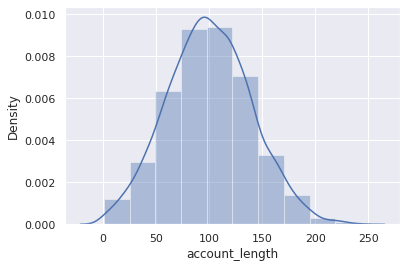

In [ ]:
numeric_info(data.account_length, bins=10)

Исходные данные: Можно видеть, что признак распределен приблизительно нормально со средним 100 и стандартным отклонением 39 

min      1.000000
max    238.000000
25%     74.000000
50%    101.000000
75%    126.000000
std     39.699029
Name: account_length, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


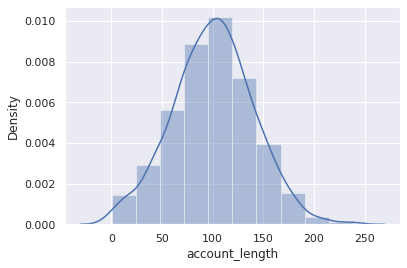

In [ ]:
numeric_info(test.account_length, bins=10)

Валидационные данные: Можно видеть, что признак распределен приблизительно нормально со средним 101 и стандартным отклонением 39. Есть небольшая скошенность вправо.

### 3. area_code

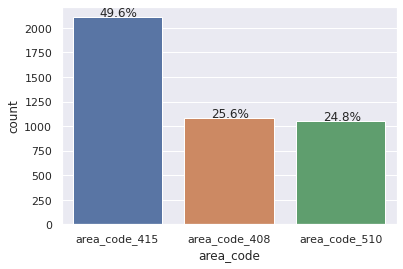

In [ ]:
categorical_info("area_code", data, rotate=0,
                 x_shift_mult=0.3, percentage=True)

Исходные данные: Признак имеет три значения, половина принадлежит 415 коду, а оставшаяся часть распределена приблизительно поровну между 408 и 510 кодом. 

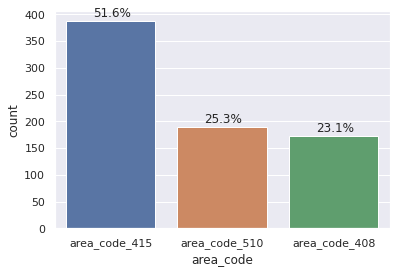

In [ ]:
categorical_info("area_code", test, rotate=0,
                 x_shift_mult=0.3, percentage=True)

Валидационные данные: Признак имеет три значения, половина принадлежит 415 коду, а оставшаяся часть распределена приблизительно поровну между 408 и 510 кодом. 

### 4. international_plan

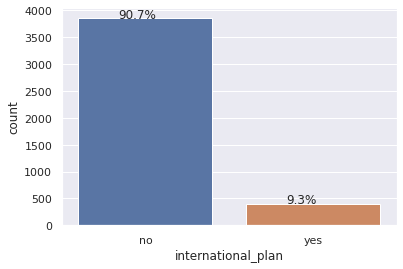

In [ ]:
categorical_info("international_plan", data, rotate=0,
                 x_shift_mult=0.3, percentage=True)

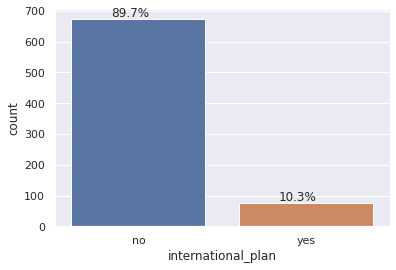

In [ ]:
categorical_info("international_plan", test, rotate=0,
                 x_shift_mult=0.3, percentage=True)

Исходные и валидационные данные имеют похожие распределения. Примерно 90% не имеет международного плана обслуживания, а 10% имеет. 

### 5. voice_mail_plan

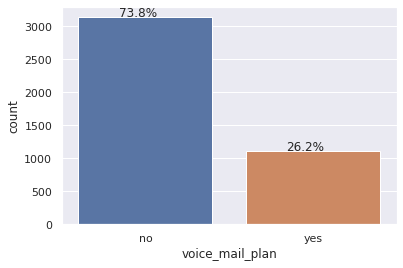

In [ ]:
categorical_info("voice_mail_plan", data, rotate=0,
                 x_shift_mult=0.3, percentage=True)

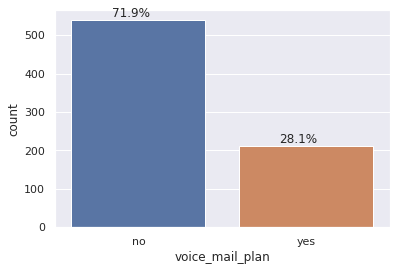

In [ ]:
categorical_info("voice_mail_plan", test, rotate=0,
                 x_shift_mult=0.3, percentage=True)

Исходные и валидационные данные имеют похожие распределения. Примерно 72% не имеет голосовой почты, а 28% имеет. 

### 6. number_vmail_messages

min     0.000000
max    52.000000
25%     0.000000
50%     0.000000
75%    16.000000
std    13.439882
Name: number_vmail_messages, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


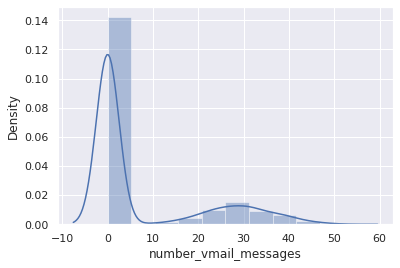

In [ ]:
numeric_info(data.number_vmail_messages, bins=10)

min     0.000000
max    51.000000
25%     0.000000
50%     0.000000
75%    21.000000
std    14.123712
Name: number_vmail_messages, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


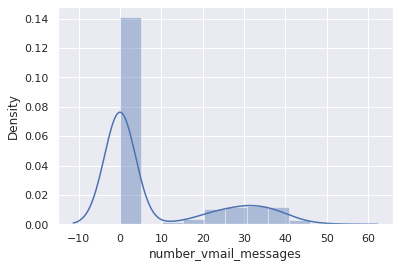

In [ ]:
numeric_info(test.number_vmail_messages, bins=10)

Исходные и валидационные данные имеют похожие распределения. В обоих распределениях наблюдается пик в нуле (не имеют голосовых сообщений). Если же построить эти распределения только для тех, у кого количество сообщений больше нуля, то можно увидеть, что они близки к нормальному со средним около 30 и стандартным отклонением 7.

min     4.000000
max    52.000000
25%    24.000000
50%    29.000000
75%    34.000000
std     7.833516
Name: number_vmail_messages, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


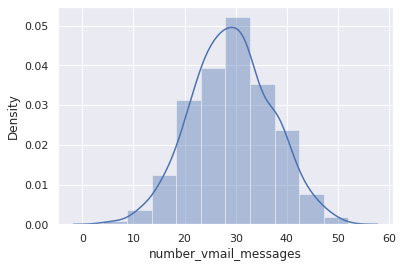

In [ ]:
numeric_info(data[data.number_vmail_messages >
                  0].number_vmail_messages, bins=10)

min     9.000000
max    51.000000
25%    24.000000
50%    31.000000
75%    36.000000
std     7.702945
Name: number_vmail_messages, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


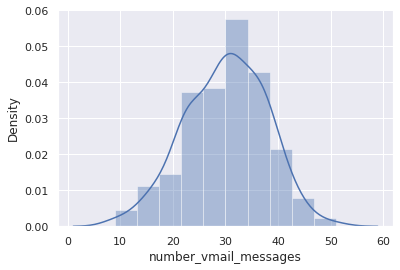

In [ ]:
numeric_info(test[test.number_vmail_messages >
                  0].number_vmail_messages, bins=10)

### 7. total_day_minutes

min      0.000000
max    351.500000
25%    143.325000
50%    180.450000
75%    216.200000
std     54.012373
Name: total_day_minutes, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


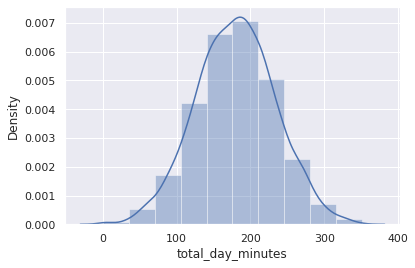

In [ ]:
numeric_info(data.total_day_minutes, bins=10)

min     12.500000
max    350.800000
25%    146.625000
50%    178.200000
75%    215.975000
std     53.258337
Name: total_day_minutes, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


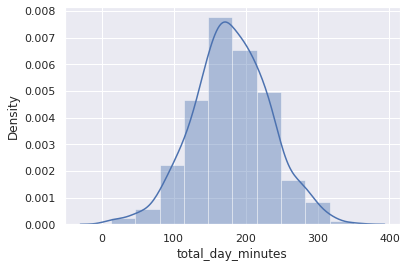

In [ ]:
numeric_info(test.total_day_minutes, bins=10)

Исходные и валидационные данные имеют похожие распределения. Они близки к нормальному со средним 179 и стандартным отклонением 53. Также стоит отметить, что признак имеет высокое значение корреляции (1.0) с признаком total_day_charge, что неудивительно, так как сумма платежа пропорциональна количеству минут разговоров. 

### 8. total_day_calls

min      0.000000
max    165.000000
25%     87.000000
50%    100.000000
75%    113.000000
std     19.850817
Name: total_day_calls, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


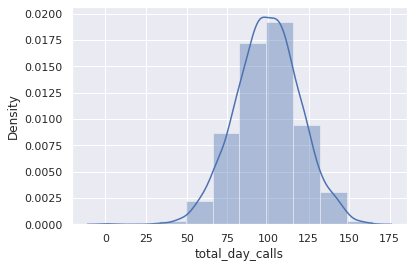

In [ ]:
numeric_info(data.total_day_calls, bins=10)

min     39.000000
max    163.000000
25%     88.000000
50%    101.000000
75%    114.000000
std     19.718539
Name: total_day_calls, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


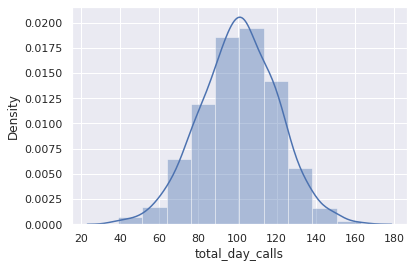

In [ ]:
numeric_info(test.total_day_calls, bins=10)

Исходные и валидационные данные имеют похожие распределения. Они близки к нормальному со средним 100 и стандартным отклонением 20. 

### 9. total_day_charge

min     0.000000
max    59.760000
25%    24.365000
50%    30.680000
75%    36.750000
std     9.182096
Name: total_day_charge, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


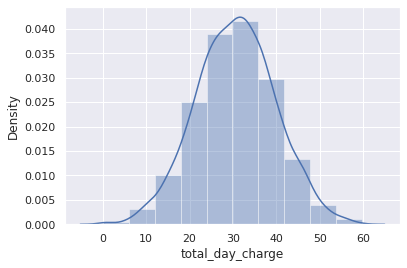

In [ ]:
numeric_info(data.total_day_charge, bins=10)

min     2.130000
max    59.640000
25%    24.925000
50%    30.295000
75%    36.715000
std     9.053756
Name: total_day_charge, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


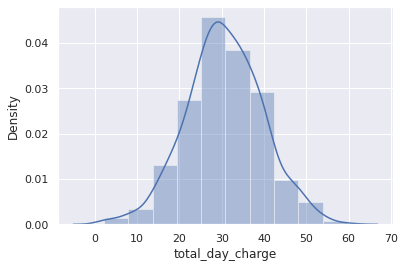

In [ ]:
numeric_info(test.total_day_charge, bins=10)

Исходные и валидационные данные имеют похожие распределения. Они близки к нормальному со средним 30 и стандартным отклонением 9. 

### 10. total_eve_minutes

min      0.000000
max    359.300000
25%    165.925000
50%    200.700000
75%    233.775000
std     50.249518
Name: total_eve_minutes, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


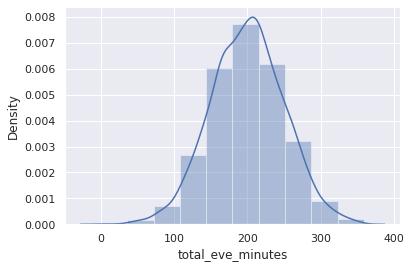

In [ ]:
numeric_info(data.total_eve_minutes, bins=10)

min     31.200000
max    363.700000
25%    166.800000
50%    203.350000
75%    235.975000
std     52.185471
Name: total_eve_minutes, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


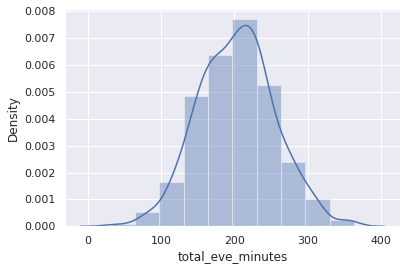

In [ ]:
numeric_info(test.total_eve_minutes, bins=10)

Исходные и валидационные данные имеют похожие распределения. Они близки к нормальному со средним 200 и стандартным отклонением 50. Также стоит отметить, что признак имеет высокое значение корреляции (1.0) с признаком total_eve_charge, что неудивительно, так как сумма платежа пропорциональна количеству минут разговоров. 

### 11. total_eve_calls

min      0.000000
max    170.000000
25%     87.000000
50%    100.000000
75%    114.000000
std     19.908591
Name: total_eve_calls, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


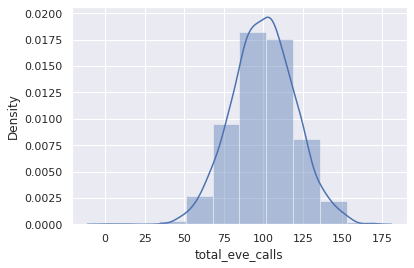

In [ ]:
numeric_info(data.total_eve_calls, bins=10)

min     37.000000
max    164.000000
25%     87.000000
50%    101.000000
75%    113.000000
std     19.367535
Name: total_eve_calls, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


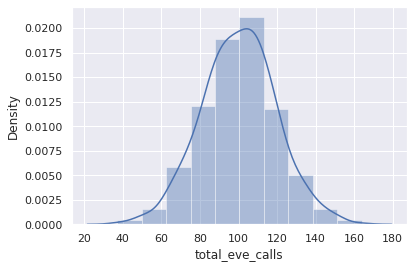

In [ ]:
numeric_info(test.total_eve_calls, bins=10)

Исходные и валидационные данные имеют похожие распределения. Они близки к нормальному со средним 100 и стандартным отклонением 20. 

### 12. total_eve_charge

min     0.000000
max    30.540000
25%    14.102500
50%    17.060000
75%    19.867500
std     4.271212
Name: total_eve_charge, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


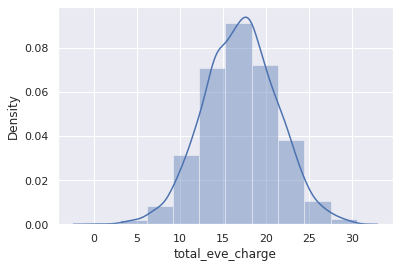

In [ ]:
numeric_info(data.total_eve_charge, bins=10)

min     2.650000
max    30.910000
25%    14.177500
50%    17.285000
75%    20.057500
std     4.435638
Name: total_eve_charge, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


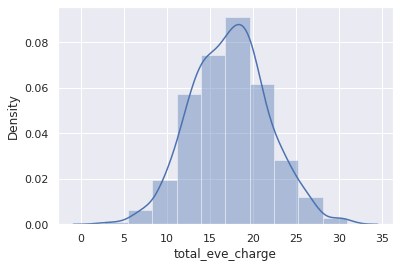

In [ ]:
numeric_info(test.total_eve_charge, bins=10)

### 13. total_night_minutes

min      0.000000
max    395.000000
25%    167.225000
50%    200.450000
75%    234.700000
std     50.353548
Name: total_night_minutes, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


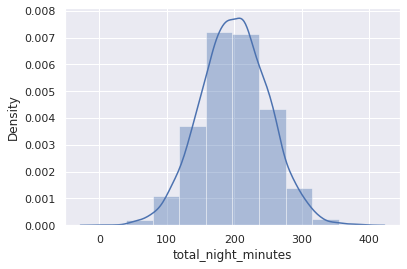

In [ ]:
numeric_info(data.total_night_minutes, bins=10)

min     50.900000
max    364.300000
25%    164.475000
50%    199.450000
75%    234.800000
std     51.531351
Name: total_night_minutes, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


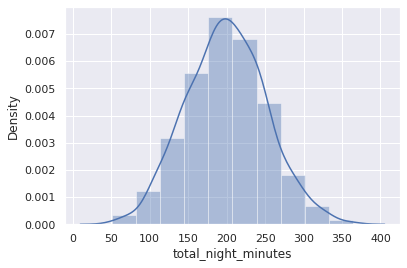

In [ ]:
numeric_info(test.total_night_minutes, bins=10)

Исходные и валидационные данные имеют похожие распределения. Они близки к нормальному со средним 200 и стандартным отклонением 50. Также стоит отметить, что признак имеет высокое значение корреляции (1.0) с признаком total_night_charge, что неудивительно, так как сумма платежа пропорциональна количеству минут разговоров. 

### 14. total_night_calls

min      0.00000
max    175.00000
25%     86.00000
50%    100.00000
75%    113.00000
std     20.09322
Name: total_night_calls, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


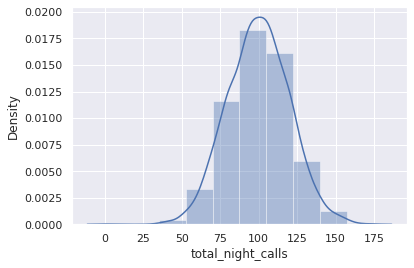

In [ ]:
numeric_info(data.total_night_calls, bins=10)

min     12.000000
max    168.000000
25%     88.000000
50%    100.500000
75%    113.000000
std     19.185238
Name: total_night_calls, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


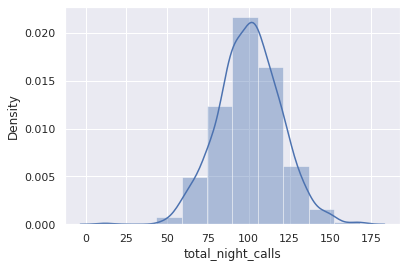

In [ ]:
numeric_info(test.total_night_calls, bins=10)

Исходные и валидационные данные имеют похожие распределения. Они близки к нормальному со средним 100 и стандартным отклонением 20. Также можно видеть более протяженный левый "хвост". 

### 15. total_night_charge

min     0.000000
max    17.770000
25%     7.522500
50%     9.020000
75%    10.560000
std     2.265922
Name: total_night_charge, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


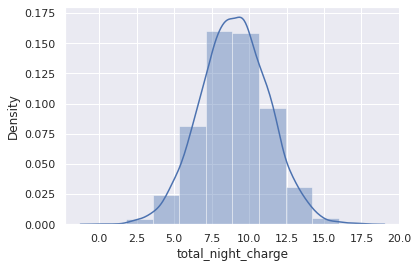

In [ ]:
numeric_info(data.total_night_charge, bins=10)

min     2.29000
max    16.39000
25%     7.40250
50%     8.97500
75%    10.56500
std     2.31892
Name: total_night_charge, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


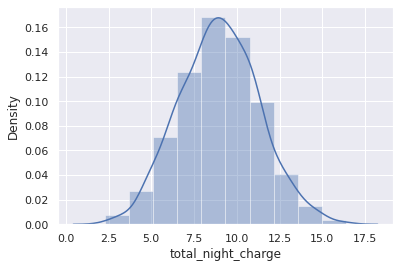

In [ ]:
numeric_info(test.total_night_charge, bins=10)

Исходные и валидационные данные имеют похожие распределения. Они близки к нормальному со средним 9 и стандартным отклонением 2. 

### 16. total_intl_minutes

min     0.000000
max    20.000000
25%     8.500000
50%    10.300000
75%    12.000000
std     2.760102
Name: total_intl_minutes, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


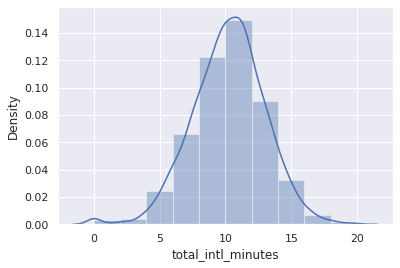

In [ ]:
numeric_info(data.total_intl_minutes, bins=10)

min     0.00000
max    18.90000
25%     8.52500
50%    10.30000
75%    12.10000
std     2.77034
Name: total_intl_minutes, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


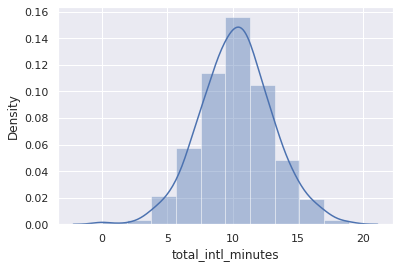

In [ ]:
numeric_info(test.total_intl_minutes, bins=10)

Исходные и валидационные данные имеют похожие распределения. Они близки к нормальному со средним 10 и стандартным отклонением 3. Отдельно стоит отметить левый "хвост" (есть абоненты без услуги междунродных звонков). Здесь также наблюдается высокая корреляция (1.0) с признаком "total_intl_charge"

### 17. total_intl_calls

min     0.000000
max    20.000000
25%     3.000000
50%     4.000000
75%     6.000000
std     2.463069
Name: total_intl_calls, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


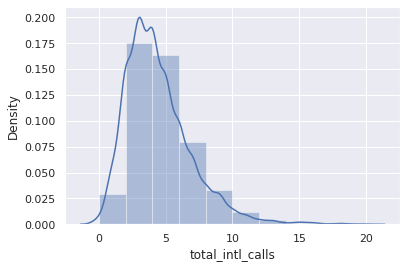

In [ ]:
numeric_info(data.total_intl_calls, bins=10)

min     0.000000
max    19.000000
25%     3.000000
50%     4.000000
75%     6.000000
std     2.421901
Name: total_intl_calls, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


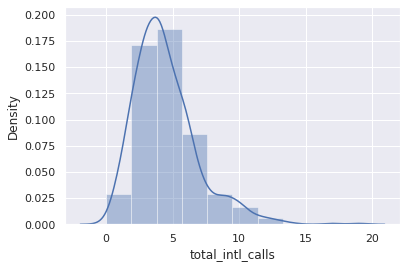

In [ ]:
numeric_info(test.total_intl_calls, bins=10)

Исходные и валидационные данные имеют похожие распределения, скошеные влево, с правым "хвостом". В среднем совершается 4 звонка со стандартным отклонением 2. 

### 18. total_intl_charge

min    0.000000
max    5.400000
25%    2.300000
50%    2.780000
75%    3.240000
std    0.745204
Name: total_intl_charge, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


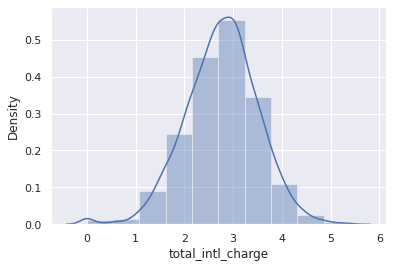

In [ ]:
numeric_info(data.total_intl_charge, bins=10)

min    0.000000
max    5.100000
25%    2.305000
50%    2.780000
75%    3.270000
std    0.747704
Name: total_intl_charge, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


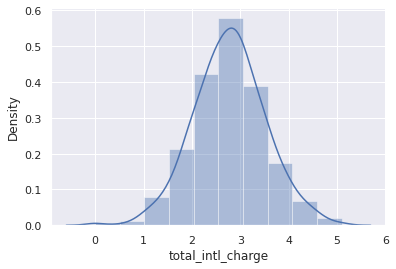

In [ ]:
numeric_info(test.total_intl_charge, bins=10)

Исходные и валидационные данные имеют похожие распределения, с левым "хвостом". В среднем значение параметра равно 2.7 со стандартным отклонением 0.7

### 19. number_customer_service_calls

min    0.000000
max    9.000000
25%    1.000000
50%    1.000000
75%    2.000000
std    1.311434
Name: number_customer_service_calls, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


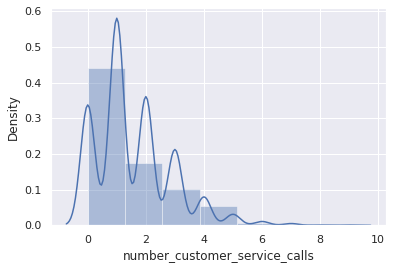

In [ ]:
numeric_info(data.number_customer_service_calls, bins=7)

min    0.000000
max    6.000000
25%    1.000000
50%    1.000000
75%    2.000000
std    1.276207
Name: number_customer_service_calls, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


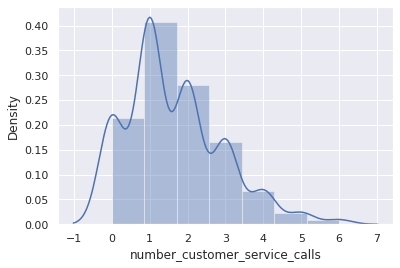

In [ ]:
numeric_info(test.number_customer_service_calls, bins=7)

Количество обращений в поддержку для обоих распределений схожи и имеют правый  "хвост". В большинстве своем люди совершают один звонок. Но есть и те, кто обращается за помощью часто (до 9 раз)

### 20. churn

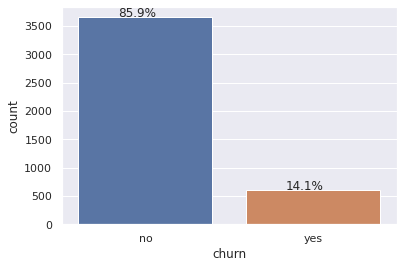

In [ ]:
categorical_info("churn", data, rotate=0, x_shift_mult=0.3, percentage=True)

Из распределения хорошо виден дисбаланс выборки относительно целевой переменной: 86% оставшихся и 14% ушедших клиентов. 

## Выводы

Представленные данные чистые, не содержат пропусков, а распределение большинства числовых признаков близко к нормальному. В ходе анализа обнаружены значимые корреляции между ткими признаками, как количество минут разговоров и оплатой за них для всех типов звонков (дневных, вечерних, ночных, международных). Несомненно важным для задачи классификации является сбалансированность выборки относительно целевой переменной. В нашем случае выборка является несбалансированной, так как соотношение классов в целевой пременной default примерно равно 6/1.

# 4. Оценка важности признаков и их корреляции

## boxplots

 Выделим отдельно категориальные и числовые переменные

In [ ]:
category_columns = list(data.columns[data.dtypes == "object"])
category_columns.remove("churn")
numeric_columns = list(
    data.columns[(data.dtypes == "int64") | (data.dtypes == "float64")])

Построим boxplots для числовых признаков относительно целевой переменной churn:

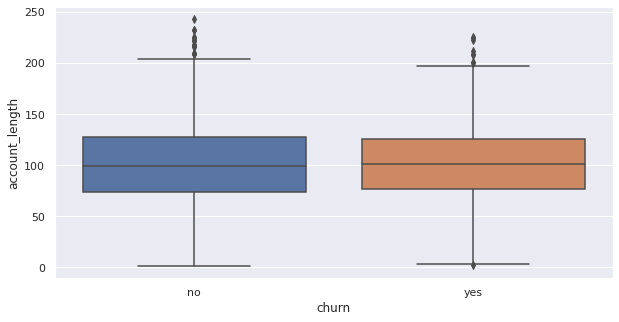

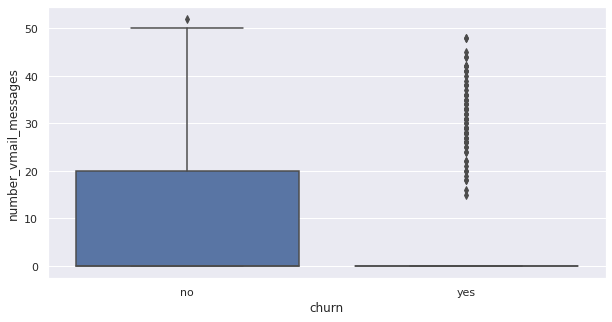

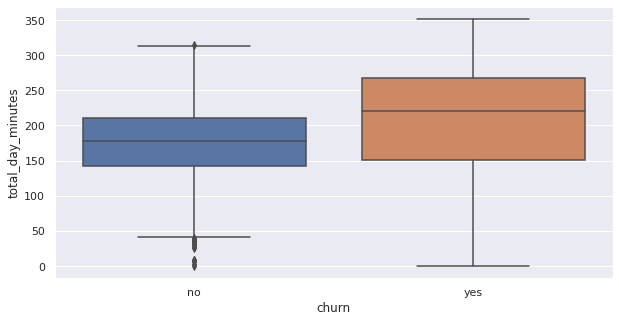

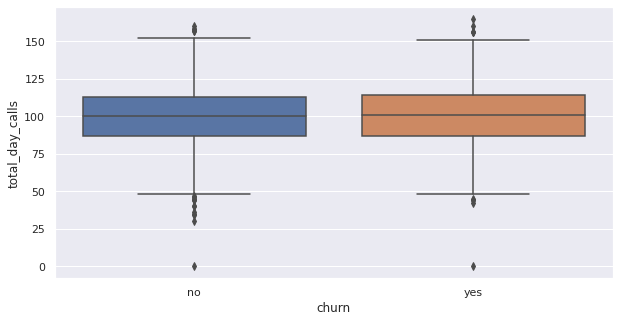

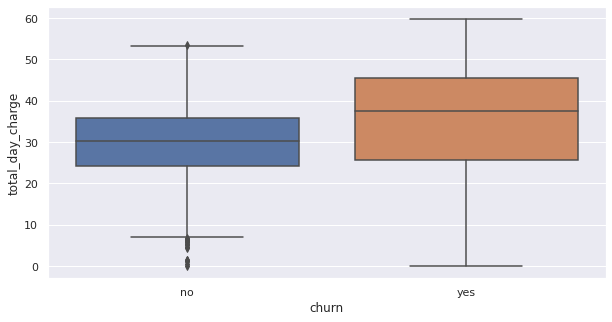

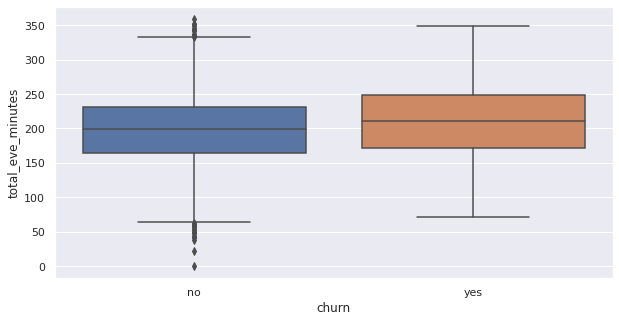

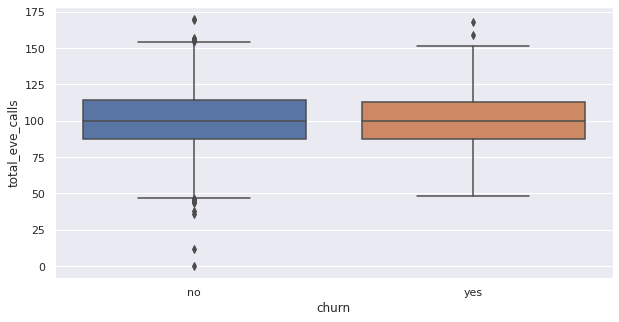

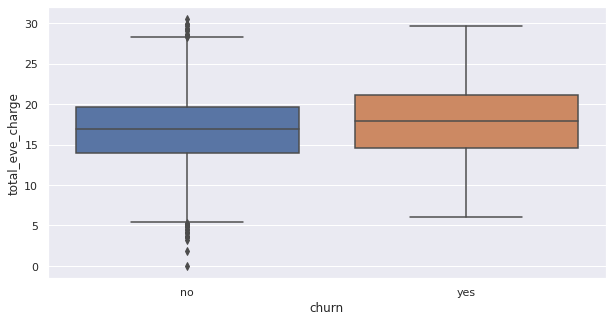

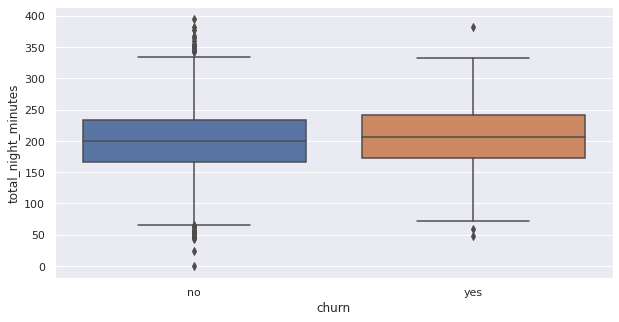

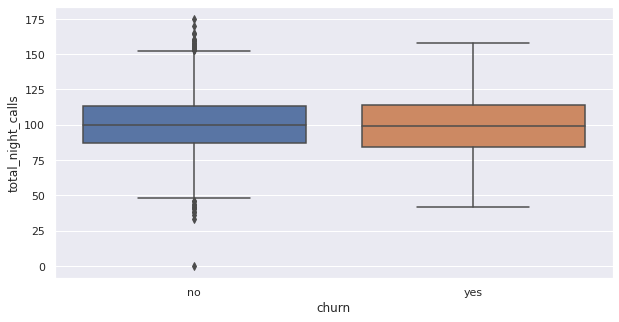

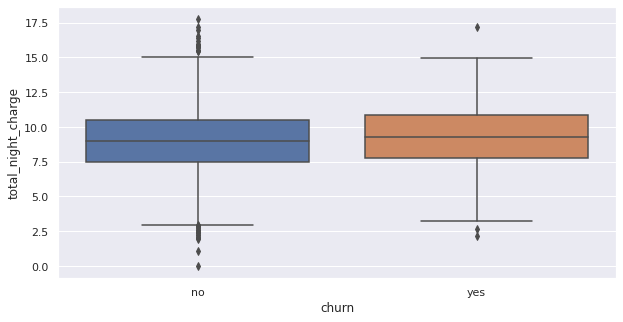

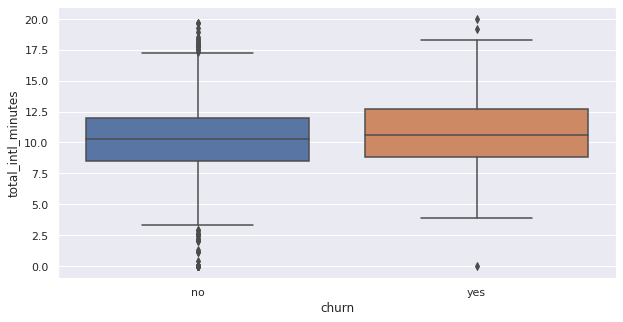

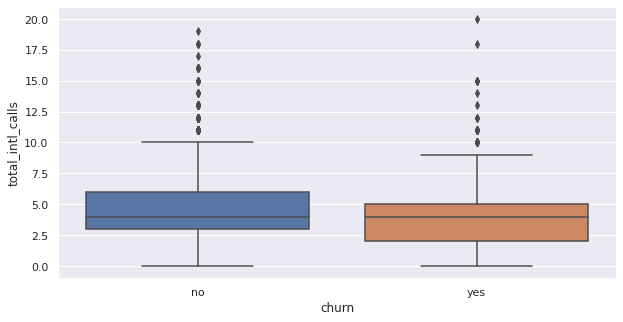

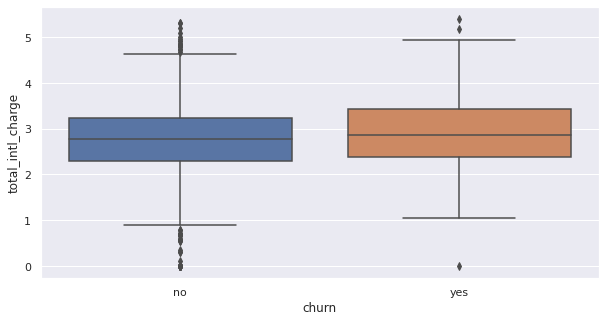

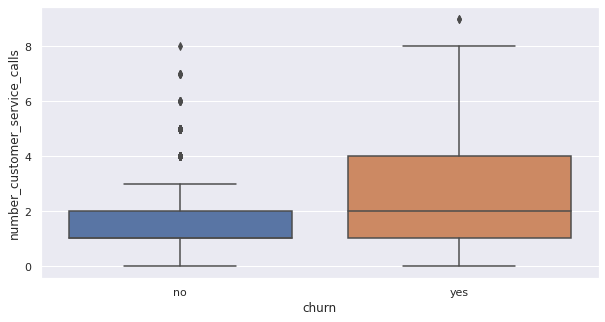

In [ ]:
for col in numeric_columns:
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.boxplot(y=col, x="churn", data=data, ax=ax)

Из построенных boxplot можно видеть, что распределения для ушедших и оставшихся клиентов наиболее отличаются для признака total_day_charge (что может говорить о том, что клиенты уходят из-за дороговизны тарифа). Также можно видеть, что среди ушедших клиентов, количество обращений в службу поддержки (number_customer_service_calls) выше, чем у оставшихся (наличие проблем в обслуживании тоже приводит к оттоку клиентов). 

In [ ]:
data.groupby("churn")[numeric_columns].agg(["mean"])[
    ["total_day_charge", "number_customer_service_calls"]]

total_day_charge number_customer_service_calls
                  mean                          mean
churn                                               
no           29.844948                      1.441676
yes          35.528679                      2.275920

## Корреляции

Таблица корреляций числовых признаков также подтверждает выводы, сделанные при EDA (pandas-profiling). Высокие значения корреляций наблюдаются у признаков, отражающих количество минут разговоров и оплату за услугу. Это наблюдается для всех звонков: дневных, вечерных, ночных, международных

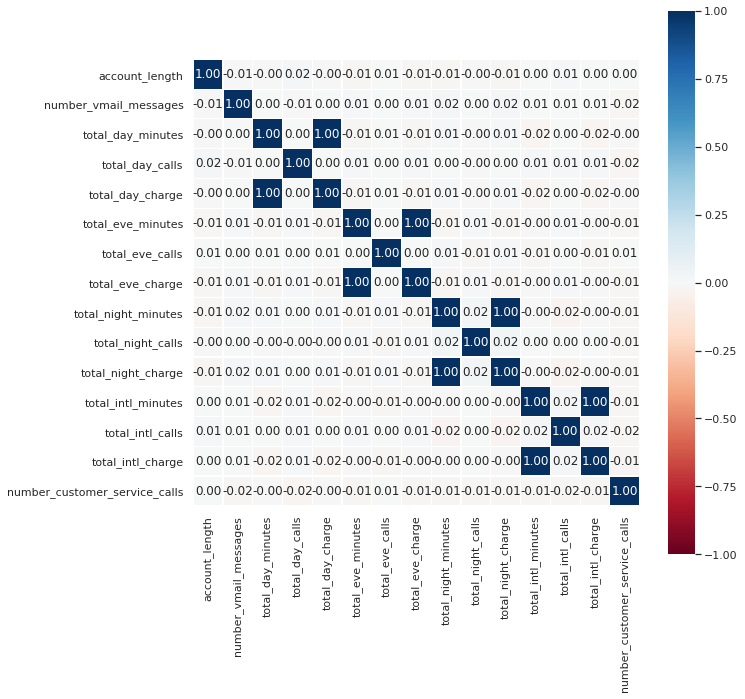

In [ ]:
plt.subplots(figsize=(10, 10))
sns.heatmap(data[numeric_columns].corr(), square=True,
            annot=True, fmt=".2f", linewidths=0.1, cmap="RdBu", vmin=-1.0, vmax=1.0)

## ANOVA

Оценим значимость переменных с помощью однофакторного дисперсионного анализа (ANOVA). Приведенное ниже распределение важности признаков также показывает, что наиболее важным признаком является число обращений в службу поддержки. 

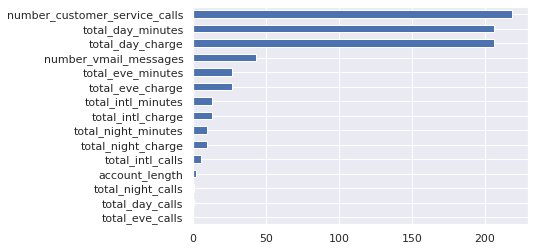

In [ ]:
imp_num = Series(f_classif(data[numeric_columns], data['churn'])[
                 0], index=numeric_columns)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

## Категориальные переменные

Для оценки значимости категориальных и бинарных переменных будем использовать функцию mutual_info_classif из библиотеки sklearn. Данная функция опирается на непараметрические методы, основанные на оценке энтропии в группах категориальных переменных.

 Преобразуем значения категориальных признаков в числа:

In [ ]:
data_copy = data.copy()

In [ ]:
encoding_columns = category_columns.copy()
encoding_columns.append("churn")
label_encoder = LabelEncoder()
for num, column in enumerate(encoding_columns):
    data_copy[column] = label_encoder.fit_transform(data[column])
    print(dict(enumerate(label_encoder.classes_)))

{0: 'AK', 1: 'AL', 2: 'AR', 3: 'AZ', 4: 'CA', 5: 'CO', 6: 'CT', 7: 'DC', 8: 'DE', 9: 'FL', 10: 'GA', 11: 'HI', 12: 'IA', 13: 'ID', 14: 'IL', 15: 'IN', 16: 'KS', 17: 'KY', 18: 'LA', 19: 'MA', 20: 'MD', 21: 'ME', 22: 'MI', 23: 'MN', 24: 'MO', 25: 'MS', 26: 'MT', 27: 'NC', 28: 'ND', 29: 'NE', 30: 'NH', 31: 'NJ', 32: 'NM', 33: 'NV', 34: 'NY', 35: 'OH', 36: 'OK', 37: 'OR', 38: 'PA', 39: 'RI', 40: 'SC', 41: 'SD', 42: 'TN', 43: 'TX', 44: 'UT', 45: 'VA', 46: 'VT', 47: 'WA', 48: 'WI', 49: 'WV', 50: 'WY'}
{0: 'area_code_408', 1: 'area_code_415', 2: 'area_code_510'}
{0: 'no', 1: 'yes'}
{0: 'no', 1: 'yes'}
{0: 'no', 1: 'yes'}


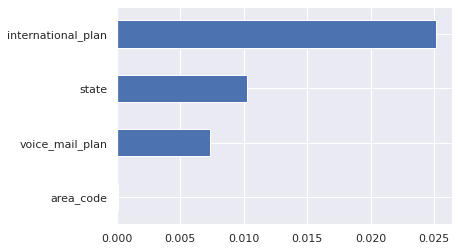

In [ ]:
imp_cat = Series(mutual_info_classif(data_copy[category_columns], data_copy['churn'],
                                     discrete_features=True), index=category_columns)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Можно видеть, что самым важным категориальным признаком является признак наличия медународного плана обслуживания. Наименее важным признаком является код округа.

## Выводы

Анализ boxplots для числовых признаков показал, что наиболее значимыми признаками для оттока клиентов являются оплата за дневные звонки total_day_charge и количество обращений в службу поддержки number_customer_service_calls. Таким образом, дороговизна дневного тарифа и наличие проблем в обслуживании могут приводить к оттоку клиентов. 

Среди признаков, отражающих количество минут разговоров и оплату за услугу, найдены высокие значения корреляций (приблизительно 1). Это наблюдается для всех звонков: дневных, вечерных, ночных, международных. 

Наиболее значимым категориальным признаком для оттока клиентов является наличие международного плана обслуживания. 


# 5. Моделирование

Вспомогательные функции

In [ ]:
def draw_roc_auc(y_test, y_pred_proba):
    # Посчитать значения ROC кривой и значение площади под кривой AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
    roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])

    plt.figure(figsize=(4, 4))
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label=f'ROC')
    plt.title(f'AUC = {roc_auc:.4f}', fontsize=15)
    plt.xlabel('False positive rate (FPR)', fontsize=15)
    plt.ylabel('True positive rate (TPR)', fontsize=15)
    plt.legend(fontsize=15)


def print_confusion_matrix(y_test, y_pred):
    ax = plt.subplot()
    fig = plt.gcf()
    fig.set_size_inches(6, 4)
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True,
                fmt=".0f", linewidths=0.1, cmap="RdBu")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('Real labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['no churn', 'churn'])
    ax.yaxis.set_ticklabels(['no churn', 'churn'])


def print_metrics(y_test, y_pred):
    print(pd.DataFrame({"Accuracy": [accuracy_score(y_test, y_pred)], "Precision": [precision_score(y_test, y_pred)],
                        "Recall": [recall_score(y_test, y_pred)], "F1_score": [f1_score(y_test, y_pred)]}))


def save_model(model, path):
    with open(path, 'wb') as file:
        pickle.dump(model, file)


def load_model(path):
    with open(path, 'rb') as file:
        model = pickle.load(file)
    return model

## Подготовка данных

Удалим переменные, которые обладают высоким коэффициентом корреляции

In [ ]:
drop_cols = ['total_day_charge', 'total_eve_charge',
             'total_night_charge', 'total_intl_charge']
data = data.drop(columns=drop_cols)
test = test.drop(columns=drop_cols)

Сделаем кодирование бинарных признаков yes/no

In [ ]:
binary = ['international_plan', 'voice_mail_plan', 'churn']
binary_map = {'yes': 1, 'no': 0}
for col in binary:
    data[col] = data[col].replace(binary_map)
    try:
        test[col] = test[col].replace(binary_map)
    except:
        continue

In [ ]:
data = data.astype({'international_plan': np.uint8,
                    "voice_mail_plan": np.uint8, "churn": np.uint8})
test = test.astype({'international_plan': np.uint8,
                    "voice_mail_plan": np.uint8})

Выполним dummy-кодирование для категориальных переменных

In [ ]:
category = ['state', 'area_code']

for col in category:
    data = pd.concat([data, pd.get_dummies(
        data[col], prefix=col, drop_first=True)], axis=1)
    test = pd.concat([test, pd.get_dummies(
        test[col], prefix=col, drop_first=True)], axis=1)

data = data.drop(columns=category)
test = test.drop(columns=category)

Выделим числовые переменные

In [ ]:
numeric_columns = list(
    data.columns[(data.dtypes == "int64") | (data.dtypes == "float64")])

Выделим признаки для моделирования и целевую переменную

In [ ]:
features = list(data.columns)
features.remove("churn")
target = "churn"

Разделим данные на тренировочную и валидационную выборки

In [ ]:
data_train, data_valid = train_test_split(
    data, test_size=0.3, random_state=42, stratify=data[target])

Масштабируем числовые признаки 

In [ ]:
scaler = StandardScaler()

X_train = data_train[features].copy()
y_train = data_train[target].values.ravel()
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])

X_valid = data_valid[features].copy()
y_valid = data_valid[target].values.ravel()
X_valid[numeric_columns] = scaler.transform(X_valid[numeric_columns])

X_test = test[features].copy()
X_test[numeric_columns] = scaler.transform(test[numeric_columns])

## Logistic Regression

Будем варьировать следующие параметры для поиска оптимальной модели:

* регуляризация (penalty): "l2", "None"
* параметр регуляризации (С): [1e-2;1e2]
* взвешивание классов (class_weight): 'balanced', 'None'
* решатель(solver): ‘newton-cg’, ‘lbfgs’

In [ ]:
param_grid = {"penalty": ["l2", None], "C": np.logspace(-2, 2, 5),
              "class_weight": ['balanced', None], "solver": ["newton-cg", "lbfgs"]}

In [ ]:
model = LogisticRegression(max_iter=1000, random_state=seed)
model_cv = GridSearchCV(model, param_grid, cv=3,
                        verbose=1, n_jobs=-1, scoring='f1')
model_cv.fit(X_train, y_train)
print("Best parameters: ", model_cv.best_params_)
print("F1-score :", model_cv.best_score_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Best parameters:  {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'newton-cg'}
F1-score : 0.4965857586738685


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    3.7s finished


In [ ]:
model = model_cv.best_estimator_

   Accuracy  Precision    Recall  F1_score
0      0.76   0.341646  0.765363  0.472414


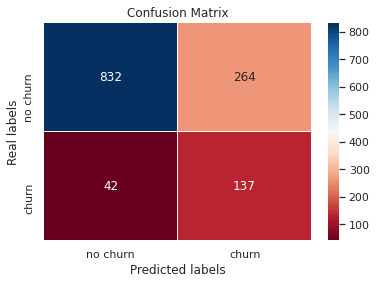

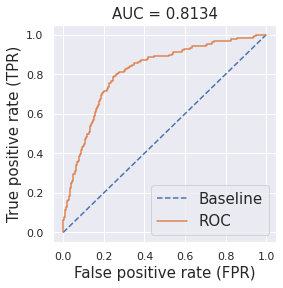

In [ ]:
y_pred = model.predict(X_valid)
y_pred_p = model.predict_proba(X_valid)
print_confusion_matrix(y_valid, y_pred)
print_metrics(y_valid, y_pred)
draw_roc_auc(y_valid, y_pred_p)

In [ ]:
submission.churn = np.where(model.predict(X_test) == 1, 'yes', 'no')
submission.to_csv('logreg.csv', index=False)

In [ ]:
save_model(model, "logreg.pkl")

## CatBoost

Будем варьировать следующие параметры для поиска оптимальной модели:

* глубина дерева (depth): 4, 6, 10
* параметр регуляризации (l2_leaf_reg): 1, 3, 5, 7, 9
* взвешивание классов (auto_class_weights): 'Balanced', 'None'

In [ ]:
param_grid = {'depth': [4, 6, 10],
              'l2_leaf_reg': [1, 3, 5, 7, 9],
              'auto_class_weights': ['Balanced', None]
              }

In [ ]:
n_iter = 3000
model = CatBoostClassifier(
    iterations=n_iter, learning_rate=0.005, random_seed=seed)
model_cv = GridSearchCV(model, param_grid, cv=3, verbose=1, n_jobs=-1)
model_cv.fit(X_train, y_train)
print("Best parameters: ", model_cv.best_params_)
print("Accuracy :", model_cv.best_score_)

Best parameters:  {'auto_class_weights': 'Balanced', 'depth': 6, 'l2_leaf_reg': 5}
Accuracy : 0.94902

In [ ]:
model = model_cv.best_estimator_

   Accuracy  Precision    Recall  F1_score
0   0.94902   0.796875  0.854749  0.824798


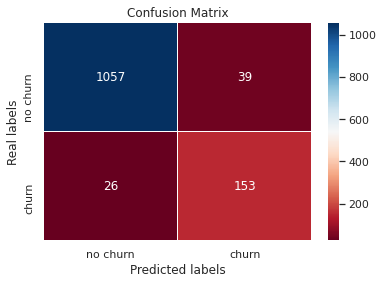

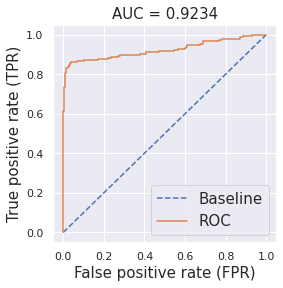

In [ ]:
y_pred = model.predict(X_valid)
y_pred_p = model.predict_proba(X_valid)
print_confusion_matrix(y_valid, y_pred)
print_metrics(y_valid, y_pred)
draw_roc_auc(y_valid, y_pred_p)

In [ ]:
submission.churn = np.where(model.predict(X_test) == 1, 'yes', 'no')
submission.to_csv('cat.csv', index=False)

In [ ]:
save_model(model, "cat.pkl")

## MLP

Оптимальными гиперпараметрами оказались

* learning_rate=0.002
* batch_size=70
* optimizer = Adam


In [ ]:
model = keras.Sequential()
model.add(keras.layers.Dense(X_train.shape[1], activation="relu"))
model.add(Dropout(0.5))
model.add(keras.layers.Dense(6, activation="relu"))
model.add(Dropout(0.5))
model.add(keras.layers.Dense(1, activation="sigmoid"))

In [ ]:
model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.002), metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=70,
                    epochs=50,
                    validation_data=(X_valid, y_valid),
                    )

Epoch 1/50
43/43 [==============================] - 1s 9ms/step - loss: 0.7472 - accuracy: 0.5371 - val_loss: 0.4600 - val_accuracy: 0.8596
Epoch 2/50
43/43 [==============================] - 0s 3ms/step - loss: 0.5306 - accuracy: 0.8357 - val_loss: 0.4104 - val_accuracy: 0.8596
Epoch 3/50
43/43 [==============================] - 0s 3ms/step - loss: 0.4995 - accuracy: 0.8500 - val_loss: 0.3937 - val_accuracy: 0.8596
Epoch 4/50
43/43 [==============================] - 0s 3ms/step - loss: 0.4969 - accuracy: 0.8558 - val_loss: 0.3784 - val_accuracy: 0.8596
Epoch 5/50
43/43 [==============================] - 0s 3ms/step - loss: 0.4604 - accuracy: 0.8618 - val_loss: 0.3609 - val_accuracy: 0.8635
Epoch 6/50
43/43 [==============================] - 0s 3ms/step - loss: 0.4499 - accuracy: 0.8720 - val_loss: 0.3501 - val_accuracy: 0.8769
Epoch 7/50
43/43 [==============================] - 0s 3ms/step - loss: 0.4369 - accuracy: 0.8677 - val_loss: 0.3337 - val_accuracy: 0.8800
Epoch 8/50
43/43 [==

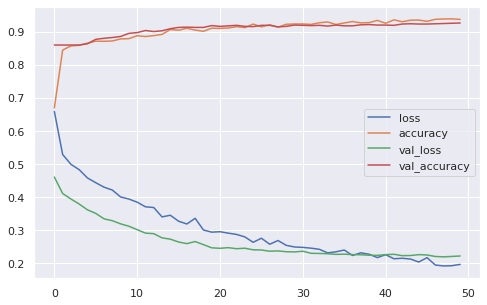

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses

   Accuracy  Precision    Recall  F1_score
0  0.926275   0.857143  0.569832  0.684564


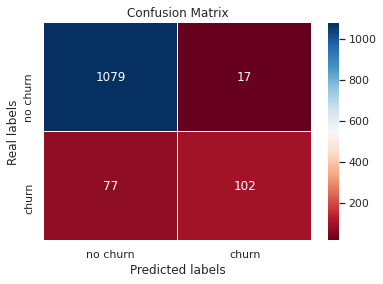

In [ ]:
y_pred = model.predict_classes(X_valid)
y_pred = model.predict_classes(X_valid)
print_confusion_matrix(y_valid, y_pred)
print_metrics(y_valid, y_pred)

In [ ]:
submission.churn = np.where(model.predict_classes(X_test) == 1, 'yes', 'no')
submission.to_csv('mlp.csv', index=False)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
model.save("mlp.h5")

## CatBoost (no preprocess)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


   Accuracy  Precision    Recall  F1_score
0  0.963137   0.971429  0.759777  0.852665


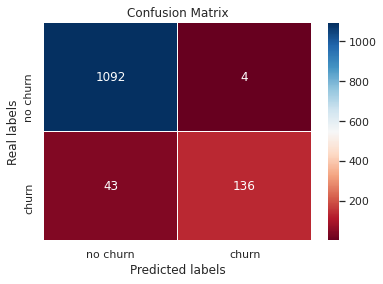

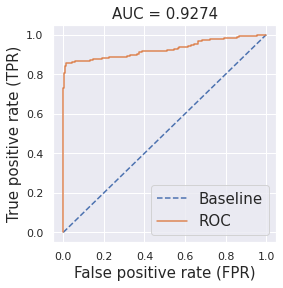

In [ ]:
data = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")
data.shape, test.shape

drop_cols = ['total_day_charge', 'total_eve_charge',
             'total_night_charge', 'total_intl_charge']
data = data.drop(columns=drop_cols)
test = test.drop(columns=drop_cols)
data.shape, test.shape

binary_map = {'yes': 1, 'no': 0}
data["churn"] = data["churn"].replace(binary_map)

data_train, data_valid = train_test_split(
    data, test_size=0.3, random_state=42, stratify=data["churn"])

y_train = data_train["churn"].values
y_valid = data_valid["churn"].values
data_train.drop(columns=["churn"], inplace=True)
data_valid.drop(columns=["churn"], inplace=True)


feature_names = list(data_train.columns)
numeric_features = list(data_train.columns[(
    data_train.dtypes == "int64") | (data_train.dtypes == "float64")])
category_features = list(set(feature_names).difference(set(numeric_features)))
category_idx = []
for feat in category_features:
    category_idx.append(list((data_train.columns == feat)).index(1))


n_iter = 3000
model = CatBoostClassifier(iterations=n_iter,
                           learning_rate=0.005,
                           random_seed=seed,
                           verbose=0)
model.fit(data_train,
          y_train,
          cat_features=category_features
          )

y_pred = model.predict(data_valid)
y_pred_p = model.predict_proba(data_valid)
print_confusion_matrix(y_valid, y_pred)
print_metrics(y_valid, y_pred)
draw_roc_auc(y_valid, y_pred_p)

In [ ]:
save_model(model, "cat_no_preproc.pkl")

## Выводы

Лучшей моделью среди LogisticRegression, CatBoost Classifier, MLP оказалась CatBoost Classifier (no preprocess) по всем рассмотренным метрикам, немного уступая лишь в метрике Recall самой себе при преобразовании переменных. 
Анализ экономических выгод от использования этих двух моделей будет проведен далее. 

In [ ]:
results = {"Accuracy": [0.760, 0.949, 0.922, 0.963],
           "Precision": [0.341, 0.799, 0.798, 0.971],
           "Recall": [0.765, 0.854, 0.597, 0.759],
           "F1-score": [0.472, 0.824, 0.683, 0.852],
           "ROC-AUC": [0.813, 0.923, None, 0.927]
           }

In [ ]:
pd.DataFrame(results, index=["LogisticRegression", "CatBoost", "MLP",
                             "CatBoost (no preprocess) "]).sort_values(by="Accuracy", ascending=False)

Accuracy  Precision  Recall  F1-score  ROC-AUC
CatBoost (no preprocess)      0.963      0.971   0.759     0.852    0.927
CatBoost                      0.949      0.799   0.854     0.824    0.923
MLP                           0.922      0.798   0.597     0.683      NaN
LogisticRegression            0.760      0.341   0.765     0.472    0.813

## Ensemble (Kaggle)

In [ ]:
log_reg = load_model("/content/logreg.pkl")
cat = load_model("/content/cat_no_preproc.pkl")
mlp = tf.keras.models.load_model("/content/mlp.h5")

In [ ]:
log_reg_proba = log_reg.predict_proba(X_test)[:, 1]
cat_proba = cat.predict_proba(test[data_train.columns])[:, 1]
mlp_proba = mlp.predict_proba(X_test).ravel()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [ ]:
cat_proba.shape, log_reg_proba.shape, mlp_proba.shape

((750,), (750,), (750,))

In [ ]:
result = (cat_proba + log_reg_proba + mlp_proba) / 3

In [ ]:
result = (cat_proba + mlp_proba) / 2

In [ ]:
result = cat_proba

In [ ]:
submission.churn = np.where(result > 0.5, 'yes', 'no')
submission.to_csv('soft_vote.csv', index=False)

Ансамблирование алгоритмов в различных их сочетаниях не позволило улучшить метрику на kaggle соревновании. Лучшее значение метрики Accuracy = 0.97 получено для CatBoost (no preprocess) 	 

# 6. Оценка экономических выгод 

## CatBoost (no preprocess)

Всего имеется 5000 клиентов, из них, согласно данным, 14% ушло. Пусть, например, прибыль с одного клиента составляет 20$, тогда
без использования модели имеем:

In [ ]:
total_clients = 5000
churn_clients = int(5000 * 0.14)  # 14% уходит
profit_per_client = 20
total_profit = total_clients * profit_per_client
total_after_churn = (total_clients - churn_clients) * profit_per_client
losses = churn_clients * profit_per_client

In [ ]:
print(f"Было клиентов: {total_clients}")
print(f"Ушедших клиентов: {churn_clients}")
print(f"Осталось клиентов: {total_clients - churn_clients}")
print(f"Средняя прибыль от клиента: {profit_per_client}$")
print(f"Ожидаемая прибыль: {total_profit}$")
print(f"Полученная прибыль: {total_after_churn}$")
print(f"Потери: {losses}$")

Было клиентов: 5000
Ушедших клиентов: 700
Осталось клиентов: 4300
Средняя прибыль от клиента: 20$
Ожидаемая прибыль: 100000$
Полученная прибыль: 86000$
Потери: 14000$


Итого имеем 700 ушедших клиентов и 14000$ потерь. Предположим, что мы бы использовали модель CatBoost Classifier, которая правильно предсказала 76% от ушедших клиентов и 97% из тех, кого модель определила уходящими, действительно ушли. То есть confusion matrix имела бы вид:

In [ ]:
# сonf_matrix =
# 4285 15
# 168  532

Пусть теперь в качестве меры удержания предлагается скидка 10%, и пусть 80% уходящих в результате этой меры 
остались, и 100% тех, для кого модель сделала ошибочное предсказание ухода приняли предложение, а также 100% тех,
кого модель не смогла определить, как уходящих, действительно ушли. 

In [ ]:
churn_predict_right = int(0.76 * churn_clients)
churn_predict_wrong_out = churn_clients - churn_predict_right
churn_predict_wrong_in = int(churn_predict_right * 0.03)

churn_predict_right_in = int(0.8 * churn_predict_right)
churn_predict_right_out = churn_predict_right - churn_predict_right_in
total_out = churn_predict_wrong_out + churn_predict_right_out
total_in_discont = churn_predict_wrong_in + churn_predict_right_in
total_in = total_clients - total_out

profit_per_client_new = round((total_in_discont / total_in) * (1 - 0.1) * profit_per_client
                              + (1 - total_in_discont / total_in) * profit_per_client, 2)

total_after_churn_new = round((total_in) * profit_per_client_new)
losses_new = total_out * profit_per_client

In [ ]:
print(
    f"Выявили уходящих {churn_predict_right}: остались {churn_predict_right_in}, ушли {churn_predict_right_out}")
print(f"Ушли в результате ошибки модели: {churn_predict_wrong_out}")
print(
    f"Остались, но им предложена скидка в результате ошибки модели: {churn_predict_wrong_in}")
print(f"Ушло всего: {total_out}")
print(f"Осталось всего: {total_in}")
print(f"Остались с условием скидки: {total_in_discont}")

Выявили уходящих 532: остались 425, ушли 107
Ушли в результате ошибки модели: 168
Остались, но им предложена скидка в результате ошибки модели: 15
Ушло всего: 275
Осталось всего: 4725
Остались с условием скидки: 440


Использование модели позволило выделить 532 уходящих клиентов, из которых 425 остались в результате проведенной кампании, а 107 все же ушли. Кроме того, 15 клиентам предложена скидка в результате ошибки модели (они и так бы остались). 168 клиентов ушли, так как модель не смогла распознать их, как уходящих. Всего же ушло 275 клиентов. Остались на услоиях скидки 440 клиентов. Если подытожить все результаты, то получим: 

In [ ]:
print(f"Без использования модели имеем:\n")
print(f"Было клиентов: {total_clients}")
print(f"Ушедших клиентов: {churn_clients}")
print(f"Осталось клиентов: {total_clients - churn_clients}")
print(f"Средняя прибыль от клиента: {profit_per_client}$")
print(f"Ожидаемая прибыль: {total_profit}$")
print(f"Полученная прибыль: {total_after_churn}$")
print(f"Потери: {losses}$")

Без использования модели имеем:

Было клиентов: 5000
Ушедших клиентов: 700
Осталось клиентов: 4300
Средняя прибыль от клиента: 20$
Ожидаемая прибыль: 100000$
Полученная прибыль: 86000$
Потери: 14000$


In [ ]:
print(f"С использованием модели имеем:\n")
print(f"Было клиентов: {total_clients}")
print(f"Ушедших клиентов: {total_out}")
print(f"Осталось клиентов: {total_clients - total_out}")
print(f"Средняя прибыль от клиента новая: {profit_per_client_new}$")
print(f"Ожидаемая прибыль: {total_profit}$")
print(f"Полученная прибыль: {total_after_churn_new}$")
print(f"Потери: {losses_new}$")

С использованием модели имеем:

Было клиентов: 5000
Ушедших клиентов: 275
Осталось клиентов: 4725
Средняя прибыль от клиента новая: 19.81$
Ожидаемая прибыль: 100000$
Полученная прибыль: 93602$
Потери: 5500$


In [ ]:
model_results = {"Было клиентов": [5000, 5000],
                 "Ушедших клиентов": [700, 275],
                 "Осталось клиентов": [4300, 4725],
                 "Средняя прибыль от клиента": [20, 19.81],
                 "Ожидаемая прибыль": [10000, 10000],
                 "Полученная прибыль": [86000, 93602],
                 "Потери": [14000, 5500]
                 }

In [ ]:
pd.DataFrame(model_results, index=["Без модели", "С моделью"])

Было клиентов  Ушедших клиентов  ...  Полученная прибыль  Потери
Без модели           5000               700  ...               86000   14000
С моделью            5000               275  ...               93602    5500

[2 rows x 7 columns]

## CatBoost 

Всего имеется 5000 клиентов, из них, согласно данным, 14% ушло. Пусть, например, прибыль с одного клиента составляет 20$, тогда
без использования модели имеем:

In [ ]:
total_clients = 5000
churn_clients = int(5000 * 0.14)  # 14% уходит
profit_per_client = 20
total_profit = total_clients * profit_per_client
total_after_churn = (total_clients - churn_clients) * profit_per_client
losses = churn_clients * profit_per_client

In [ ]:
print(f"Было клиентов: {total_clients}")
print(f"Ушедших клиентов: {churn_clients}")
print(f"Осталось клиентов: {total_clients - churn_clients}")
print(f"Средняя прибыль от клиента: {profit_per_client}$")
print(f"Ожидаемая прибыль: {total_profit}$")
print(f"Полученная прибыль: {total_after_churn}$")
print(f"Потери: {losses}$")

Было клиентов: 5000
Ушедших клиентов: 700
Осталось клиентов: 4300
Средняя прибыль от клиента: 20$
Ожидаемая прибыль: 100000$
Полученная прибыль: 86000$
Потери: 14000$


Итого имеем 700 ушедших клиентов и 14000$ потерь. Предположим, что мы бы использовали модель CatBoost Classifier, которая правильно предсказала 85% от ушедших клиентов и 80% из тех, кого модель определила уходящими, действительно ушли. То есть confusion matrix имела бы вид:

In [ ]:
# сonf_matrix =
# 4152 148
# 105  595

Пусть теперь в качестве меры удержания предлагается скидка 10%, и пусть 80% уходящих в результате этой меры 
остались, и 100% тех, для кого модель сделала ошибочное предсказание ухода приняли предложение, а также 100% тех,
кого модель не смогла определить, как уходящих, действительно ушли. 

In [ ]:
churn_predict_right = int(0.85 * churn_clients)
churn_predict_wrong_out = churn_clients - churn_predict_right
churn_predict_wrong_in = int(churn_predict_right / 4)

churn_predict_right_in = int(0.8 * churn_predict_right)
churn_predict_right_out = churn_predict_right - churn_predict_right_in
total_out = churn_predict_wrong_out + churn_predict_right_out
total_in_discont = churn_predict_wrong_in + churn_predict_right_in
total_in = total_clients - total_out

profit_per_client_new = round((total_in_discont / total_in) * (1 - 0.1) * profit_per_client
                              + (1 - total_in_discont / total_in) * profit_per_client, 2)

total_after_churn_new = round((total_in) * profit_per_client_new)
losses_new = total_out * profit_per_client

In [ ]:
print(
    f"Выявили уходящих {churn_predict_right}: остались {churn_predict_right_in}, ушли {churn_predict_right_out}")
print(f"Ушли в результате ошибки модели: {churn_predict_wrong_out}")
print(
    f"Остались, но им предложена скидка в результате ошибки модели: {churn_predict_wrong_in}")
print(f"Ушло всего: {total_out}")
print(f"Осталось всего: {total_in}")
print(f"Остались с условием скидки: {total_in_discont}")

Выявили уходящих 595: остались 476, ушли 119
Ушли в результате ошибки модели: 105
Остались, но им предложена скидка в результате ошибки модели: 148
Ушло всего: 224
Осталось всего: 4776
Остались с условием скидки: 624


Использование модели позволило выделить 595 уходящих клиентов, из которых 476 остались в результате проведенной кампании, а 119 все же ушли. Кроме того, 148 клиентам предложена скидка в результате ошибки модели (они и так бы остались). 105 клиентов ушли, так как модель не смогла распознать их, как уходящих. Всего же ушло 224 клиента. Остались на услоиях скидки 624 клиента. Если подытожить все результаты, то получим: 

In [ ]:
print(f"Без использования модели имеем:\n")
print(f"Было клиентов: {total_clients}")
print(f"Ушедших клиентов: {churn_clients}")
print(f"Осталось клиентов: {total_clients - churn_clients}")
print(f"Средняя прибыль от клиента: {profit_per_client}$")
print(f"Ожидаемая прибыль: {total_profit}$")
print(f"Полученная прибыль: {total_after_churn}$")
print(f"Потери: {losses}$")

Без использования модели имеем:

Было клиентов: 5000
Ушедших клиентов: 700
Осталось клиентов: 4300
Средняя прибыль от клиента: 20$
Ожидаемая прибыль: 100000$
Полученная прибыль: 86000$
Потери: 14000$


In [ ]:
print(f"С использованием модели имеем:\n")
print(f"Было клиентов: {total_clients}")
print(f"Ушедших клиентов: {total_out}")
print(f"Осталось клиентов: {total_clients - total_out}")
print(f"Средняя прибыль от клиента новая: {profit_per_client_new}$")
print(f"Ожидаемая прибыль: {total_profit}$")
print(f"Полученная прибыль: {total_after_churn_new}$")
print(f"Потери: {losses_new}$")

С использованием модели имеем:

Было клиентов: 5000
Ушедших клиентов: 224
Осталось клиентов: 4776
Средняя прибыль от клиента новая: 19.74$
Ожидаемая прибыль: 100000$
Полученная прибыль: 94278$
Потери: 4480$


In [ ]:
model_results = {"Было клиентов": [5000, 5000],
                 "Ушедших клиентов": [700, 224],
                 "Осталось клиентов": [4300, 4776],
                 "Средняя прибыль от клиента": [20, 19.74],
                 "Ожидаемая прибыль": [10000, 10000],
                 "Полученная прибыль": [86000, 94278],
                 "Потери": [14000, 4480]
                 }

In [ ]:
pd.DataFrame(model_results, index=["Без модели", "С моделью"])

Было клиентов  Ушедших клиентов  ...  Полученная прибыль  Потери
Без модели           5000               700  ...               86000   14000
С моделью            5000               224  ...               94278    4480

[2 rows x 7 columns]

 ## Сравнение экономических выгод, выводы

In [ ]:
model_results = {"Ушедших клиентов": [700, 275, 224],
                 "Осталось клиентов": [4300, 4725, 4776],
                 "Средняя прибыль от клиента": [20, 19.81, 19.74],
                 "Ожидаемая прибыль": [10000, 10000, 10000],
                 "Полученная прибыль": [86000, 93602, 94278],
                 "Потери": [14000, 5500, 4480]
                 }

In [ ]:
pd.DataFrame(model_results, index=[
             "Без модели", "CatBoost (no preprocess)", "CatBoost"])

Ушедших клиентов  ...  Потери
Без модели                             700  ...   14000
CatBoost (no preprocess)               275  ...    5500
CatBoost                               224  ...    4480

[3 rows x 6 columns]

Несмотря на лучшие показатели относительно метрик (кроме recall), применение модели CatBoost (no preprocess) привело к большему оттоку клиентов и большим потерям. Исходя из этого, можно сказать, что оптимальной моделью в обозначенных выше условиях является CatBoost.  

Использование этой модели привело к оттоку только лишь 224 клиентов вместо 700, сократив тем самым отток почти в три раза, кроме того, полученная прибыль составила 94278 (с учетом акции, направленной на удержание клиентов), вместо 86000, полученных без использования модели. Таким образом, удалось получить почти на 10% больше прибыли. Потери, понесенные компанией в результате оттока клиентов с применением модели, в три раза меньше, чем без модели (4480 вместо 14000)

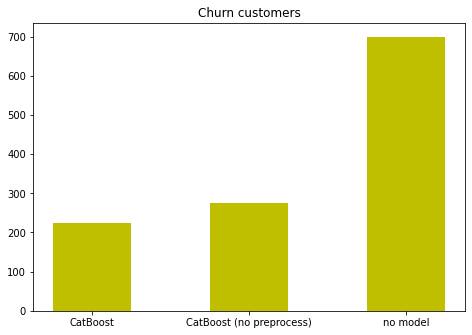

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
way = ['CatBoost', 'CatBoost (no preprocess)', 'no model']
churn_customers = [224, 275, 700]
ax.bar(way, churn_customers, width=0.5, color='y')
plt.title("Churn customers")
plt.show()

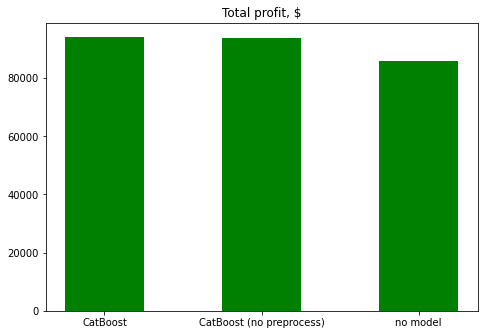

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
way = ['CatBoost', 'CatBoost (no preprocess)', 'no model']
profit = [94278, 93602, 	86000]
ax.bar(way, profit, width=0.5, color='g')
plt.title("Total profit, $")
plt.show()

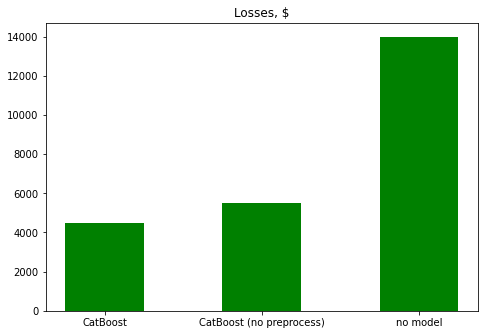

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
way = ['CatBoost', 'CatBoost (no preprocess)', 'no model']
losses = [4480, 5500, 14000]
ax.bar(way, losses, width=0.5, color='g')
plt.title("Losses, $")
plt.show()

# 7. Интерпретация результатов работы классификатора

Проведем интерпретацию результатов классификатора CatBoost с помощью библиотеки Lime:

In [ ]:
pip install lime

     |████████████████████████████████| 276kB 5.9MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283846 sha256=edabb57f9f0bb7208e2ef2ac2723f228624900ce1b0668c1f5642709178c2d9c
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [ ]:
import lime
from lime import lime_tabular

In [ ]:
data = pd.read_csv("/content/train.csv")

Уберем признаки с высокой корреляцией и категориальные:

In [ ]:
drop_cols = ['total_day_minutes',
             'total_eve_minutes',
             'total_night_minutes',
             'total_intl_minutes',
             'state',
             'area_code',
             'international_plan',
             'voice_mail_plan'
             ]
data = data.drop(columns=drop_cols)
binary_map = {'yes': 1, 'no': 0}
data["churn"] = data["churn"].replace(binary_map)

Обучим модель:

In [ ]:
data_train, data_valid = train_test_split(
    data, test_size=0.3, random_state=42, stratify=data["churn"])

In [ ]:
y_train = data_train["churn"].values
y_valid = data_valid["churn"].values
data_train = data_train.drop(columns=["churn"])
data_valid = data_valid.drop(columns=["churn"])

In [ ]:
n_iter = 3000
model = CatBoostClassifier(iterations=n_iter,
                           learning_rate=0.005,
                           random_seed=seed,
                           verbose=0)
model.fit(data_train, y_train)

Распределение важности признаков показывает, что ключевыми являются: оплата дневных звонков, оплата вечерних звонков и  число обращений в службу поддержки:

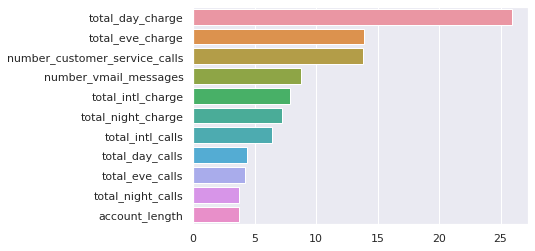

In [ ]:
idx = np.flip(np.argsort(model.feature_importances_))
sns.barplot(x=model.feature_importances_[
            idx[:20]], y=np.array(model.feature_names_)[idx[:20]])

Посмотрим на средние значения наиболее значимых признаков в разрезе оттока:

In [ ]:
data.groupby("churn").agg(["mean"])[
    ["total_day_charge", "total_eve_charge", "number_customer_service_calls"]]

total_day_charge total_eve_charge number_customer_service_calls
                  mean             mean                          mean
churn                                                                
0            29.844948        16.878743                      1.441676
1            35.528679        17.847207                      2.275920

Создадим объект для интерпретации:

In [ ]:
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(data_train),
    feature_names=data_train.columns,
    class_names=["no churn", "churn"],
    mode='classification'
)

Выясним индексы клиентов, которых модель определила как уходящих

In [ ]:
np.where(model.predict(data_valid) == 1)[0][:5]

array([21, 31, 35, 41, 58])

In [ ]:
def print_explanation(customer_idx):
    exp = explainer.explain_instance(
        data_row=data_valid.iloc[customer_idx],
        predict_fn=model.predict_proba
    )
    exp.show_in_notebook(show_table=True)
    return exp.as_list()

In [ ]:
def print_explanation_customer(customer):
    exp = explainer.explain_instance(
        data_row=customer,
        predict_fn=model.predict_proba
    )
    exp.show_in_notebook(show_table=True)
    return exp.as_list()

Построим на результаты работы библиотеки для двух клиентов: с индексом 1 - оставшегося, с индексом 21 - ушедшего. Можно видеть, что она выводит вероятности принадлежности к тому или иному классу, но что самое важное, разделяет признаки по их вкладу в определение класса клиента и определяет границы их изменения.

In [ ]:
print_explanation(1)

[('number_vmail_messages <= 0.00', 0.08521481886124493),
 ('1.00 < number_customer_service_calls <= 2.00', -0.05593128259452445),
 ('total_intl_calls <= 3.00', 0.05233696178489019),
 ('total_night_charge <= 7.53', -0.03368356569396579),
 ('total_day_charge <= 24.43', -0.029631115751731163),
 ('14.09 < total_eve_charge <= 17.04', -0.017092528378589638),
 ('total_night_calls > 114.00', -0.013821956843581557),
 ('2.78 < total_intl_charge <= 3.27', -0.011973927920538613),
 ('101.00 < total_eve_calls <= 114.00', -0.010339271805075394),
 ('99.00 < account_length <= 126.00', 0.002308523496504743)]

In [ ]:
print_explanation(21)

[('total_day_charge > 36.86', 0.23313193809239913),
 ('number_customer_service_calls <= 1.00', -0.11309334664359882),
 ('number_vmail_messages <= 0.00', 0.09001957007032503),
 ('total_eve_charge > 19.82', 0.07091744656185424),
 ('total_intl_calls <= 3.00', 0.04617551162306552),
 ('99.00 < account_length <= 126.00', 0.0158567930034558),
 ('87.00 < total_eve_calls <= 101.00', -0.010978297046814654),
 ('2.30 < total_intl_charge <= 2.78', -0.005336657717403245),
 ('100.00 < total_night_calls <= 114.00', -0.0030468682055445596),
 ('9.02 < total_night_charge <= 10.56', 0.0029994786406810194)]

total_day_charge - главный признак для модели. Можно видеть, что для оставшегося клиента он равен 22.8, что меньше среднего значения 29.8 для всех оставшихся клиентов. Для ушедшего клиента он равен 47.82, что больше среднего значения 35.5 для ушедших клиентов. Попробуем уменьшить значение этого признака для ушедшего клиента на 25%

In [ ]:
churn_customer = data_valid.iloc[21]
churn_customer["total_day_charge"] = churn_customer["total_day_charge"] * 0.75
churn_customer

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


account_length                   105.000
number_vmail_messages              0.000
total_day_calls                  124.000
total_day_charge                  35.865
total_eve_calls                   96.000
total_eve_charge                  25.630
total_night_calls                109.000
total_night_charge                 9.130
total_intl_calls                   3.000
total_intl_charge                  2.350
number_customer_service_calls      0.000
Name: 1637, dtype: float64

In [ ]:
print_explanation_customer(churn_customer)

[('number_customer_service_calls <= 1.00', -0.1171617941729233),
 ('30.75 < total_day_charge <= 36.86', -0.107670238687075),
 ('number_vmail_messages <= 0.00', 0.08100557754809663),
 ('total_eve_charge > 19.82', 0.04380172076190612),
 ('total_intl_calls <= 3.00', 0.03798414385792447),
 ('9.02 < total_night_charge <= 10.56', 0.019090815318201906),
 ('99.00 < account_length <= 126.00', 0.009315621355901582),
 ('100.00 < total_night_calls <= 114.00', 0.008570262142238187),
 ('total_day_calls > 113.00', 0.006307077531313156),
 ('87.00 < total_eve_calls <= 101.00', -0.003033252219041294)]

Как можно видеть, 25% скидка на дневные звонки позволила предотвратить уход клиента. 

# 8. Основные итоги проекта

В ходе работы над проектом выполнено построение модели машинного обучения, предсказывающей отток клиентов. Для её построения был проведен разведывательный анализ данных, в ходе которого были определены наиболее важные признаки, а также сделаны выводы о распределении целевой переменной. Для выбора наилучшей модели были построено несколько моделей машинного обучения: CatBoost, LogisticRegression, MLP и CatBoost без предобработки признаков (no preprocess). На основе сравнения метрик, полученных на валидационной выборке лучшей была признана модель CatBoost (no preprocess). Полученные  значения метрик: Accuracy = 0.963, Precision = 0.971, Recall = 0.759.	Проведенный анализ экономических выгод от использования модели показал, что с точки зрения оттока клиентов и полученной прибыли, оптимальной является модель CatBoost. Она позволила сократить отток клиентов почти в три раза, увеличить прибыль на 10% и уменьшить денежные потери в три раза. Для интерпретации результатов работы классификатора была использована библиотека Lime. На примере одного из ушедших клиентов было показано, что 25% скидка на дневные звонки могла бы предотвратить его уход.